Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

from joblib import dump
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

Function declaration for statistical sampling from data packages

In [2]:
def dummy_label(label):
    labels = {'Straight': 0, 'Curved': 1, 'Leaning': 2, 'Tilt': 3, 'Reaching': 4}
    return labels[label]

def down_sampling(df, column_name, window_size, step_size):
    return pd.Series([df[column_name].values[i: i + window_size]
                      for i in range(0, df.shape[0] - window_size, step_size)])

def processing(lists, raw_column_names, function_names, functions):
    df = pd.DataFrame()
    column_names = [f"{column}_{function}" for function in function_names for column in raw_column_names]
    for i, function in enumerate(functions):
        for j, lst in enumerate(lists):
            name = column_names[i * len(lists) + j]
            df[name] = lst.apply(function)
    return df

In [3]:
# Reading data
data = pd.read_csv('filtered_data.csv')

# Sampling packages from data
window_size = 120
step_size = 60
packages_list = [down_sampling(data, column, window_size, step_size) for column in data.columns[1:]]

# Transforming a label into a numeric format
data['dummy_label'] = data['label'].apply(dummy_label)
labels = np.array([stats.mode(data['dummy_label'][i: i + window_size])[0]
                   for i in range(0, data.shape[0] - window_size, step_size)])

Function for demonstrating the distribution of classes in the dataset

In [4]:
def plot_count_and_pie(df):

    label_counts = df['label'].value_counts()

    plt.figure(figsize=(9, 4), facecolor='white')
    sns.set_style('ticks')

    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='label', palette='viridis')
    sns.despine()
    plt.ylabel('')
    plt.xlabel('')
    
    plt.subplot(1, 2, 2)
    plt.pie(label_counts, labels=label_counts.index, autopct='%.1f%%', startangle=90)
    plt.suptitle('Activity Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

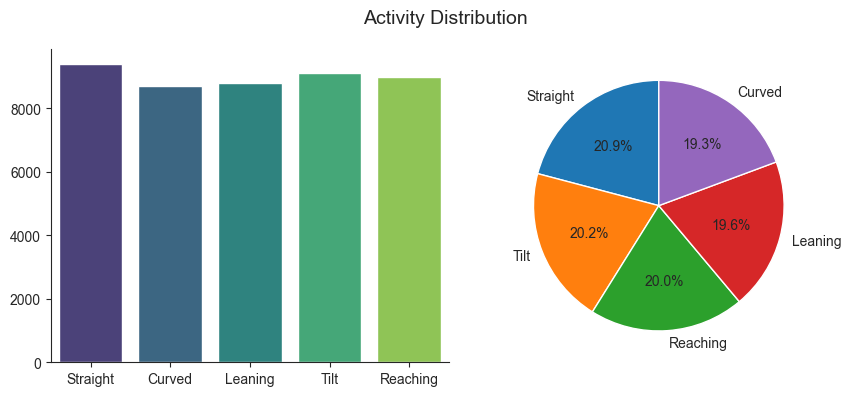

In [5]:
plot_count_and_pie(data)

In [6]:
# Defining the required functions
function_names = [
    'mean', 
    'std', 
    'aad', 
    'min', 
    'max', 
    'median', 
    'mad', 
    'IQR', 
    'neg-count', 
    'pos-count', 
    'above-mean',
    'energy'
    ]

functions = [
    lambda x: x.mean(),  # Mean
    lambda x: x.std(),  # Standard deviation
    lambda x: np.mean(np.absolute(x - np.mean(x))),  # Mean absolute deviation from the mean
    lambda x: x.min(),  # Minimum value
    lambda x: x.max(),  # Maximum value
    lambda x: np.median(x),  # Median
    lambda x: np.median(np.absolute(x - np.median(x))),  # Median absolute deviation from the median
    lambda x: np.percentile(x, 75) - np.percentile(x, 25),  # Interquartile range
    lambda x: np.sum(x < 0),  # Count of values less than zero
    lambda x: np.sum(x > 0),  # Count of values greater than zero
    lambda x: np.sum(x > x.mean()),  # Count of values greater than the mean
    lambda x: np.sum(x**2)/100  # Sum of squares normalized by length
]

# Starts the algorithm for computing statistical parameters
base_fdf = processing(packages_list, data.columns[1:], function_names, functions)

In [7]:
feature_df = pd.DataFrame(columns=function_names)

Since there are so many features, algorithms need to be applied to find the best parameters. Below are the algorithms that were used to analyze and select the best parameters

* Mutual Information Classification (MIC)

In [8]:
importances = mutual_info_classif(base_fdf, labels)
feat_importances = pd.Series(importances, base_fdf.columns)
mic = list(feat_importances.sort_values(ascending=False).index)
counts = Counter(i.split('_')[-1] for i in mic[:len(base_fdf.columns) // 2])
feature_df.loc['MIC'] = dict(Counter(i.split('_')[-1] for i in mic[:len(base_fdf.columns) // 2]))

* Random Forest Classifier (RFC)

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=101)
rf_model.fit(base_fdf, labels)
importances = rf_model.feature_importances_
rf_dict = {feature_name: importance for feature_name, importance in zip(base_fdf.columns, importances)}
filtered_dict = {key: value for key, value in rf_dict.items() if value > 0}
sorted_dict = dict(sorted(filtered_dict.items(), key=lambda item: item[1], reverse=True))
keys = list(sorted_dict.keys())[:len(base_fdf.columns) // 2]
dct = Counter(i.split('_')[-1] for i in keys)
feature_df.loc['RFC'] = Counter(i.split('_')[-1] for i in keys)

* Select K Best with F-statistic (SKB)

In [10]:
k = len(base_fdf.columns) // 2
fvalue_selector = SelectKBest(score_func=f_classif, k=k)
X_new = fvalue_selector.fit_transform(base_fdf, labels)
scores = fvalue_selector.scores_
top_feature_indices = np.argsort(scores)[-k:]
top_features = [base_fdf.columns[i] for i in top_feature_indices]
feature_df.loc['SKB'] = Counter(i.split('_')[-1] for i in top_features)

In [11]:
feature_df.fillna(0, inplace=True)
feature_df.astype(int)

,mean,std,aad,min,max,median,mad,IQR,neg-count,pos-count,above-mean,energy
MIC,6,11,11,10,9,7,4,2,1,0,10,1
RFC,5,11,10,7,6,8,7,5,4,0,8,1
SKB,1,13,13,10,7,3,6,7,6,0,6,0


In [12]:
# Defining the required functions
function_names = [
    'std', 
    'aad', 
    'mad', 
    'median',
    'IQR'
]

functions = [
    lambda x: x.std(), 
    lambda x: np.mean(np.absolute(x - np.mean(x))),
    lambda x: np.median(np.absolute(x - np.median(x))),
    lambda x: np.median(x),
    lambda x: np.percentile(x, 75) - np.percentile(x, 25)
]
# Starts the algorithm for computing statistical parameters
df = processing(packages_list, data.columns[1:], function_names, functions)
print(f'The count of features in a dataframe: {len(df.columns)}.')

The count of features in a dataframe: 60.


In [13]:
df.to_csv('data/featured_data.csv', index=False)

Constructing an algorithm to train a simple neural network with 4 layers, using the swish function for activation

In [14]:
accuracy_list = []
for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.4, random_state=101)
    y_train = to_categorical(np.asarray(y_train))
    y_test = to_categorical(np.asarray(y_test))

    units = x_train.shape[1]
    model = Sequential()
    model.add(Dense(units * 2, input_shape = [units], activation='swish'))
    model.add(Dense(units, activation='swish'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=75, batch_size=128, verbose=0, validation_data=(x_test, y_test))
    predict = model.evaluate(x_test, y_test)[1]
    accuracy_list.append(predict)
    print("Accuracy:", predict)
print(f'Average accuracy: {np.around(np.mean(accuracy_list) * 100, 2)}%.')
dump(model, 'model.sav')

10/10 [==============================] - 0s 997us/step - loss: 0.0167 - accuracy: 0.9967
Accuracy: 0.996666669845581
10/10 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9933
Accuracy: 0.9933333396911621
10/10 [==============================] - 0s 1ms/step - loss: 0.0165 - accuracy: 0.9967
Accuracy: 0.996666669845581
10/10 [==============================] - 0s 997us/step - loss: 0.0126 - accuracy: 1.0000
Accuracy: 1.0
10/10 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 1.0000
Accuracy: 1.0
10/10 [==============================] - 0s 997us/step - loss: 0.0119 - accuracy: 1.0000
Accuracy: 1.0
10/10 [==============================] - 0s 998us/step - loss: 0.0168 - accuracy: 0.9967
Accuracy: 0.996666669845581
10/10 [==============================] - 0s 998us/step - loss: 0.0136 - accuracy: 0.9967
Accuracy: 0.996666669845581
10/10 [==============================] - 0s 998us/step - loss: 0.0230 - accuracy: 0.9933
Accuracy: 0.9933333396

['model.sav']

Loss graph with epochs

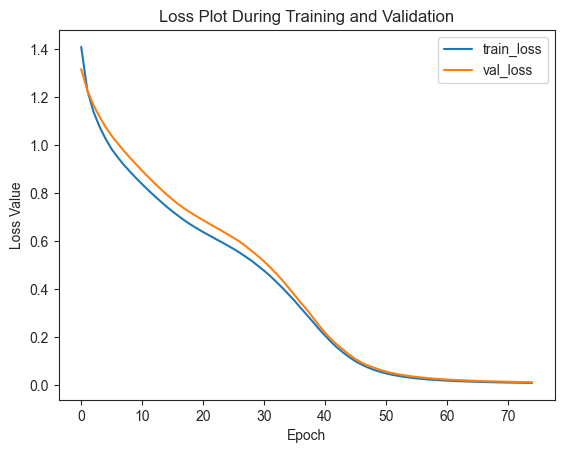

In [15]:
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].iloc[:].plot()
plt.title('Loss Plot During Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Confusion matrix

10/10 [==============================] - 0s 776us/step


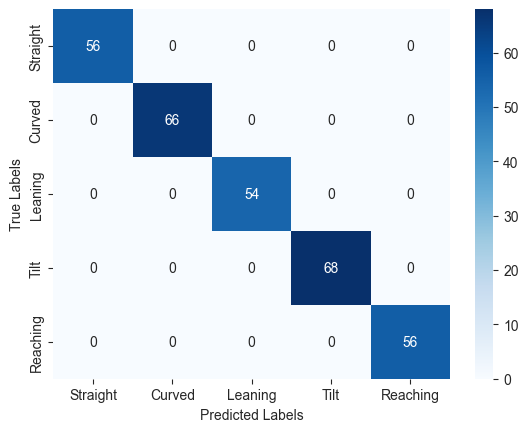

In [16]:
predictions = np.argmax(model.predict(x_test), axis=1)
text_labels = data['label'].unique()
y_test_text = [text_labels[i] for i in np.argmax(y_test, axis=1)]
predictions_text = [text_labels[i] for i in predictions]
confusion_df = pd.DataFrame(confusion_matrix(y_test_text, predictions_text), index=text_labels, columns=text_labels)
sns.heatmap(data=confusion_df, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification report

In [17]:
class_report = classification_report(np.argmax(y_test, axis=1), predictions, target_names=data['label'].unique(), output_dict=True)
report_df = pd.DataFrame(class_report).transpose()
for column in report_df.columns:
    if column != 'f1-score':
        report_df.loc['accuracy', column] = ''
print(tabulate(report_df, headers='keys', tablefmt='simple_outline'))

┌──────────────┬─────────────┬──────────┬────────────┬───────────┐
│              │ precision   │ recall   │   f1-score │ support   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Straight     │ 1.0         │ 1.0      │          1 │ 68.0      │
│ Curved       │ 1.0         │ 1.0      │          1 │ 56.0      │
│ Leaning      │ 1.0         │ 1.0      │          1 │ 66.0      │
│ Tilt         │ 1.0         │ 1.0      │          1 │ 56.0      │
│ Reaching     │ 1.0         │ 1.0      │          1 │ 54.0      │
│ accuracy     │             │          │          1 │           │
│ macro avg    │ 1.0         │ 1.0      │          1 │ 300.0     │
│ weighted avg │ 1.0         │ 1.0      │          1 │ 300.0     │
└──────────────┴─────────────┴──────────┴────────────┴───────────┘
